In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.applications.efficientnet_v2 import preprocess_input as base_preprocess
from glob import glob
import matplotlib.pyplot as plt
import itertools


2025-07-13 00:45:19.716690: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-13 00:45:19.758158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752342319.791708   33863 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752342319.799276   33863 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752342319.831921   33863 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# === CONFIG ===
IMAGE_ROOT_DIR = "./skincancer-dataset/HAM10000_images"
METADATA_PATH = "./skincancer-dataset/HAM10000_metadata"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50
SAVE_DIR = './saved_models_skincancer'


In [3]:
# === LOAD & PREPROCESS METADATA ===
df = pd.read_csv(METADATA_PATH)
le = LabelEncoder()
df['label_idx'] = le.fit_transform(df['dx'])


In [4]:
# Map image_id to full image path (search recursively)
all_image_paths = glob(os.path.join(IMAGE_ROOT_DIR, '**', '*.jpg'), recursive=True)
image_map = {os.path.splitext(os.path.basename(p))[0]: p for p in all_image_paths}
df['image_path'] = df['image_id'].map(image_map)
df = df.dropna(subset=['image_path'])


In [5]:
# Split dataset
image_paths = df['image_path'].values
label_indices = df['label_idx'].values
num_classes = len(le.classes_)

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, label_indices, test_size=0.1, stratify=label_indices, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.1, stratify=train_labels, random_state=42)


In [6]:
# === TF DATA PIPELINE WITH AUGMENTATION ===
def decode_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=num_classes)
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label

def build_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_data = build_dataset(train_paths, train_labels, training=True)
val_data = build_dataset(val_paths, val_labels, training=False)
test_data = build_dataset(test_paths, test_labels, training=False)


I0000 00:00:1752342323.922670   33863 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8990 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [7]:
# === MODEL SETUP ===
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [8]:
# === CALLBACKS ===
os.makedirs(SAVE_DIR, exist_ok=True)
checkpoint_path = os.path.join(SAVE_DIR, 'EfficientNetV2S.h5')

callbacks = [
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy', verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, mode='max', min_lr=1e-4, verbose=1)
]


In [9]:
# === TRAIN ===
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/50


I0000 00:00:1752342381.329342   33974 service.cc:152] XLA service 0x7f47080038a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752342381.329514   33974 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-07-13 00:46:22.900648: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752342390.192199   33974 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-13 00:46:37.809384: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43717', 4 bytes spill stores, 4 bytes spill loads

2025-07-13 00:46:37.987594: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43717_

506/507 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6552 - loss: 1.0451

2025-07-13 00:48:12.463170: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43717', 8 bytes spill stores, 8 bytes spill loads

2025-07-13 00:48:12.466347: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43717', 12 bytes spill stores, 12 bytes spill loads

2025-07-13 00:48:12.813883: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43717', 112 bytes spill stores, 112 bytes spill loads

2025-07-13 00:48:12.831858: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43717_0', 176 bytes spill stores, 524 bytes spill loads

2025-07-13 00:48:13.139085: I ex

507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.6552 - loss: 1.0448

2025-07-13 00:49:04.927744: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4258', 12 bytes spill stores, 12 bytes spill loads

2025-07-13 00:49:04.969306: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4258', 8 bytes spill stores, 8 bytes spill loads

2025-07-13 00:49:05.269397: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4258_0', 176 bytes spill stores, 524 bytes spill loads

2025-07-13 00:49:05.269589: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4258', 8 bytes spill stores, 8 bytes spill loads

2025-07-13 00:49:05.412124: I external/l


Epoch 1: val_accuracy improved from -inf to 0.59645, saving model to ./saved_models_skincancer/EfficientNetV2S.h5


507/507 ━━━━━━━━━━━━━━━━━━━━ 210s 230ms/step - accuracy: 0.6553 - loss: 1.0445 - val_accuracy: 0.5965 - val_loss: 1.0586 - learning_rate: 0.0010
Epoch 2/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7264 - loss: 0.7750
Epoch 2: val_accuracy improved from 0.59645 to 0.66962, saving model to ./saved_models_skincancer/EfficientNetV2S.h5


507/507 ━━━━━━━━━━━━━━━━━━━━ 44s 84ms/step - accuracy: 0.7264 - loss: 0.7750 - val_accuracy: 0.6696 - val_loss: 1.4099 - learning_rate: 0.0010
Epoch 3/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7439 - loss: 0.7044
Epoch 3: val_accuracy did not improve from 0.66962
507/507 ━━━━━━━━━━━━━━━━━━━━ 44s 84ms/step - accuracy: 0.7439 - loss: 0.7044 - val_accuracy: 0.0144 - val_loss: 5.2288 - learning_rate: 0.0010
Epoch 4/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7589 - loss: 0.6698
Epoch 4: val_accuracy did not improve from 0.66962
507/507 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.7590 - loss: 0.6698 - val_accuracy: 0.6696 - val_loss: 1.4690 - learning_rate: 0.0010
Epoch 5/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7787 - loss: 0.6107
Epoch 5: val_accuracy did not improve from 0.66962
507/507 ━━━━━━━━━━━━━━━━━━━━ 37s 71ms/step - accuracy: 0.7787 - loss: 0.6107 - val_accuracy: 0.0144 - val_loss: 21.2136 - learning_rate: 0.0010
Epoch 6/50
50

507/507 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.8372 - loss: 0.4539 - val_accuracy: 0.7783 - val_loss: 0.7678 - learning_rate: 5.0000e-04
Epoch 9/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8801 - loss: 0.3410
Epoch 9: val_accuracy did not improve from 0.77827
507/507 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.8801 - loss: 0.3409 - val_accuracy: 0.7339 - val_loss: 1.7594 - learning_rate: 5.0000e-04
Epoch 10/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8883 - loss: 0.2992
Epoch 10: val_accuracy did not improve from 0.77827
507/507 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.8883 - loss: 0.2992 - val_accuracy: 0.7095 - val_loss: 1.2482 - learning_rate: 5.0000e-04
Epoch 11/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9034 - loss: 0.2685
Epoch 11: val_accuracy did not improve from 0.77827
507/507 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.9035 - loss: 0.2684 - val_accuracy: 0.6619 - val_loss: 2.2720 - learning_rate: 5.000

507/507 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.9881 - loss: 0.0390 - val_accuracy: 0.8570 - val_loss: 0.7223 - learning_rate: 1.2500e-04
Epoch 20/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9910 - loss: 0.0287
Epoch 20: val_accuracy did not improve from 0.85698
507/507 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.9910 - loss: 0.0286 - val_accuracy: 0.7572 - val_loss: 1.1740 - learning_rate: 1.2500e-04
Epoch 21/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9929 - loss: 0.0192
Epoch 21: val_accuracy did not improve from 0.85698
507/507 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.9929 - loss: 0.0192 - val_accuracy: 0.8392 - val_loss: 0.8590 - learning_rate: 1.2500e-04
Epoch 22/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9919 - loss: 0.0313
Epoch 22: val_accuracy improved from 0.85698 to 0.86475, saving model to ./saved_models_skincancer/EfficientNetV2S.h5


507/507 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9919 - loss: 0.0312 - val_accuracy: 0.8647 - val_loss: 0.7818 - learning_rate: 1.2500e-04
Epoch 23/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9966 - loss: 0.0115
Epoch 23: val_accuracy did not improve from 0.86475
507/507 ━━━━━━━━━━━━━━━━━━━━ 38s 72ms/step - accuracy: 0.9966 - loss: 0.0115 - val_accuracy: 0.7561 - val_loss: 1.4111 - learning_rate: 1.2500e-04
Epoch 24/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9959 - loss: 0.0145
Epoch 24: val_accuracy improved from 0.86475 to 0.87251, saving model to ./saved_models_skincancer/EfficientNetV2S.h5


507/507 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.9959 - loss: 0.0145 - val_accuracy: 0.8725 - val_loss: 0.7870 - learning_rate: 1.2500e-04
Epoch 25/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9948 - loss: 0.0146
Epoch 25: val_accuracy did not improve from 0.87251
507/507 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.9948 - loss: 0.0146 - val_accuracy: 0.8537 - val_loss: 0.8965 - learning_rate: 1.2500e-04
Epoch 26/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9929 - loss: 0.0198
Epoch 26: val_accuracy did not improve from 0.87251
507/507 ━━━━━━━━━━━━━━━━━━━━ 37s 71ms/step - accuracy: 0.9929 - loss: 0.0198 - val_accuracy: 0.7749 - val_loss: 1.7039 - learning_rate: 1.2500e-04
Epoch 27/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9963 - loss: 0.0109
Epoch 27: val_accuracy did not improve from 0.87251
507/507 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.9963 - loss: 0.0109 - val_accuracy: 0.7018 - val_loss: 1.2506 - learning_rate: 1.2

In [10]:
model=load_model('./saved_models_skincancer/EfficientNetV2S.h5')


In [11]:
# Evaluate model on test dataset
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8578 - loss: 0.8527

2025-07-13 01:20:21.946267: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4258', 12 bytes spill stores, 12 bytes spill loads

2025-07-13 01:20:21.955228: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4258', 8 bytes spill stores, 8 bytes spill loads

2025-07-13 01:20:22.102765: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4258_0', 176 bytes spill stores, 524 bytes spill loads

2025-07-13 01:20:22.223238: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4258', 112 bytes spill stores, 112 bytes spill loads

2025-07-13 01:20:22.468298: I extern

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.8574 - loss: 0.8545
Test Loss: 0.9090
Test Accuracy: 0.8423


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Get true labels (class indices) and predicted labels
true_labels = []
pred_labels = []

for batch_images, batch_labels in test_data:
    preds = model.predict(batch_images)
    pred_labels.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(batch_labels.numpy(), axis=1))  # batch_labels is one-hot

# Classification report
print(classification_report(true_labels, pred_labels, target_names=le.classes_))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━

2025-07-13 01:20:48.010382: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, np.round(pred_labels))

cm


array([[ 26,   1,   3,   0,   1,   2,   0],
       [  5,  42,   1,   0,   1,   1,   1],
       [  7,   6,  69,   0,   9,  19,   0],
       [  0,   0,   0,  11,   1,   0,   0],
       [  8,   2,   9,   1,  52,  39,   0],
       [  1,   5,   8,   0,  23, 632,   2],
       [  0,   0,   0,   0,   2,   0,  12]])

Normalized confusion matrix


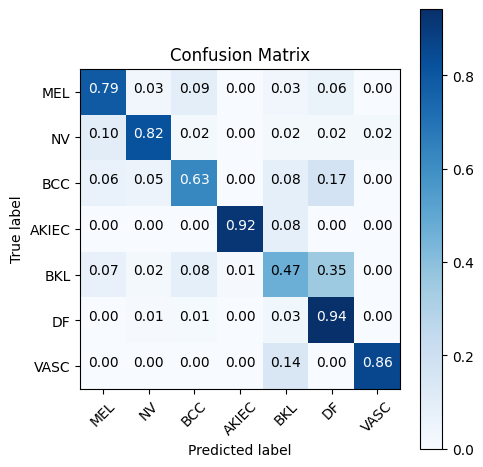

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm_plot_labels = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)


63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step
Class 0 → y_true shape: (1002,), y_score shape: (1002,), unique: [0 1]
Class 1 → y_true shape: (1002,), y_score shape: (1002,), unique: [0 1]
Class 2 → y_true shape: (1002,), y_score shape: (1002,), unique: [0 1]
Class 3 → y_true shape: (1002,), y_score shape: (1002,), unique: [0 1]
Class 4 → y_true shape: (1002,), y_score shape: (1002,), unique: [0 1]
Class 5 → y_true shape: (1002,), y_score shape: (1002,), unique: [0 1]
Class 6 → y_true shape: (1002,), y_score shape: (1002,), unique: [0 1]


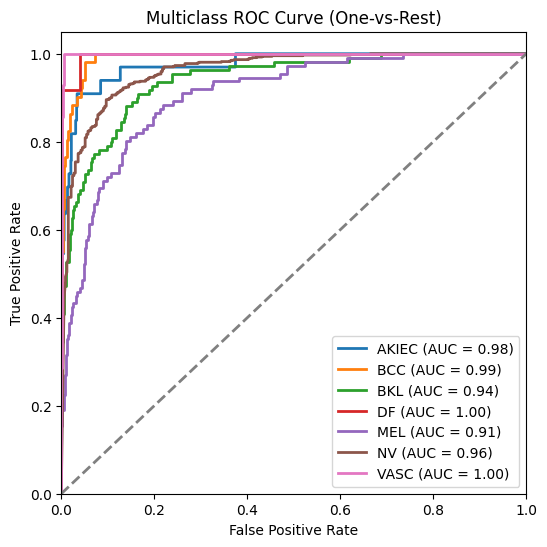

In [15]:
from tensorflow.keras.utils import to_categorical

class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
num_classes = len(class_names)

# Convert labels to one-hot
test_labels_cat = to_categorical(test_labels, num_classes=num_classes)

# Predict
predictions = model.predict(test_data)

# Plot ROC
plt.figure(figsize=(6, 6))
for class_index in range(num_classes):
    y_true = test_labels_cat[:, class_index].astype(int)
    y_score = predictions[:, class_index]

    print(f"Class {class_index} → y_true shape: {y_true.shape}, y_score shape: {y_score.shape}, unique: {np.unique(y_true)}")

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{class_names[class_index]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()


In [16]:
image_titles = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
num_images = len(image_titles)


2025-07-13 01:21:04.447751: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


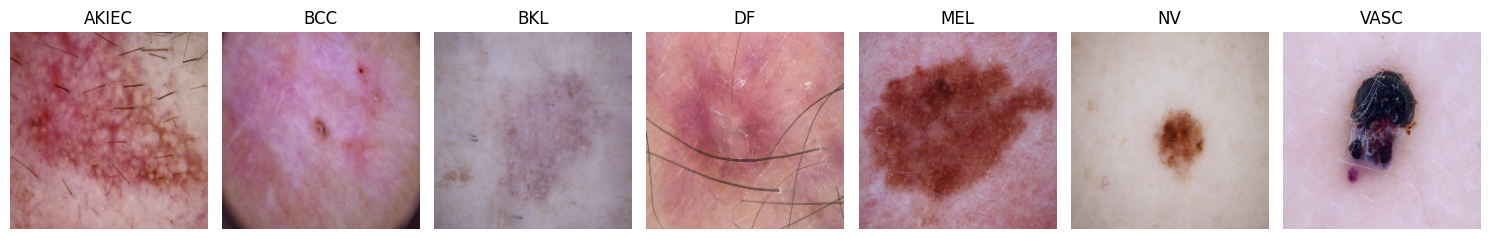

In [17]:
# Extract a batch of images and labels from test_data
all_images = []
all_labels = []

for images, labels in test_data.unbatch().take(1000):  # Take 1000 samples max
    all_images.append(images.numpy())
    all_labels.append(np.argmax(labels.numpy()))

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Find the first image index for each class
class_indices = [np.where(all_labels == i)[0][0] for i in range(num_classes)]

# Plot one image per class
fig, ax = plt.subplots(1, num_classes, figsize=(15, 3))

for i in range(num_classes):
    ax[i].imshow(all_images[class_indices[i]])
    ax[i].set_title(class_names[i])
    ax[i].axis('off')

plt.tight_layout()
plt.show()

# Store these images for preprocessing if needed later
image_array = [all_images[idx] for idx in class_indices]


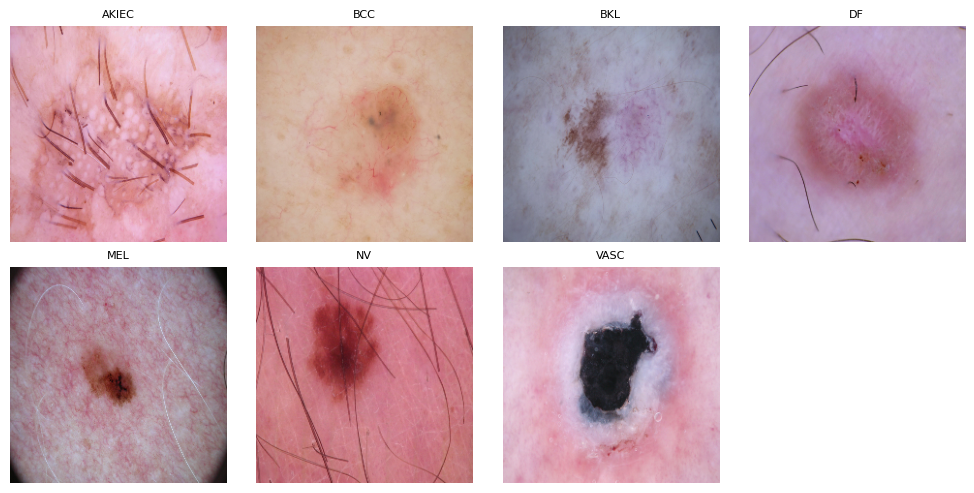

In [18]:
import numpy as np
import matplotlib.pyplot as plt

image_titles = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
num_classes = len(image_titles)

# Extract images and labels from test_data
all_images = []
all_labels = []

for img, label in test_data.unbatch():
    all_images.append(img.numpy())
    all_labels.append(np.argmax(label.numpy()))

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Prepare plot
num_rows = 2
num_cols = (num_classes + 1) // num_rows
fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 5))

image_array = []

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols

    ax[row, col].set_title(title, fontsize=8)

    # Get one random image for each class
    class_indices = np.where(all_labels == i)[0]
    random_index = np.random.choice(class_indices)

    img = all_images[random_index]
    image_array.append(img)

    ax[row, col].imshow(img)
    ax[row, col].axis('off')

# Remove any empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

# Now image_array contains one sample image per class
# Apply preprocessing if you have a custom base_preprocess function
X = base_preprocess(np.array(image_array))


In [19]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()


In [20]:
from tf_keras_vis.utils.scores import CategoricalScore

score = CategoricalScore([0, 1, 2, 3, 4, 5, 6])


2025-07-13 01:21:22.067395: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4213', 204 bytes spill stores, 204 bytes spill loads

2025-07-13 01:21:22.245716: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4213_0', 464 bytes spill stores, 1372 bytes spill loads

2025-07-13 01:21:22.683390: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4213', 5616 bytes spill stores, 5612 bytes spill loads

2025-07-13 01:21:22.688419: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4213', 5340 bytes spill stores, 5324 bytes spill loads



11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

2025-07-13 01:21:32.356003: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4213', 8 bytes spill stores, 8 bytes spill loads

2025-07-13 01:21:32.409389: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4213', 12 bytes spill stores, 12 bytes spill loads

2025-07-13 01:21:32.532522: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4213_0', 176 bytes spill stores, 524 bytes spill loads

2025-07-13 01:21:32.595377: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4213', 8 bytes spill stores, 8 bytes spill loads

2025-07-13 01:21:32.704467: I external/l

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 885ms/step


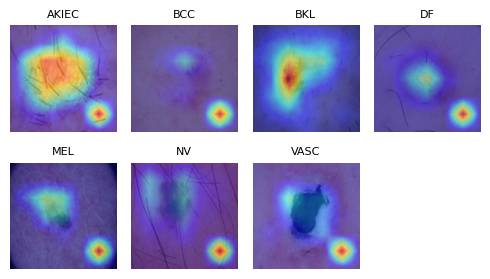

CPU times: user 33.3 s, sys: 1.73 s, total: 35 s
Wall time: 28 s


In [21]:
%%time
from matplotlib import cm
from tf_keras_vis.scorecam import Scorecam

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Calculate the number of rows and columns for subplots
num_rows = 2
num_cols = (num_images + 1) // num_rows

# Render
f, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols

    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[row, col].set_title(title, fontsize=8)
    ax[row, col].imshow(image_array[i])
    ax[row, col].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[row, col].axis('off')

# Remove any empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    f.delaxes(ax[row, col])

plt.tight_layout()
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 433ms/step


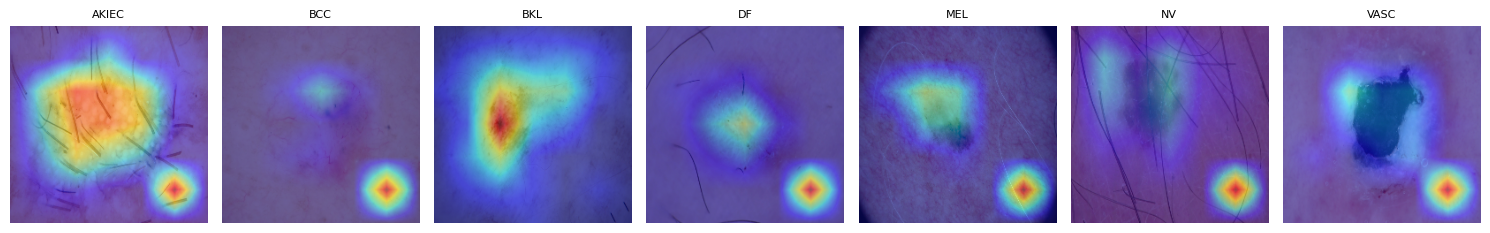

CPU times: user 15 s, sys: 1.18 s, total: 16.2 s
Wall time: 16.3 s


In [22]:
%%time
import cv2
import numpy as np
from matplotlib import pyplot as plt, cm
from tf_keras_vis.scorecam import Scorecam

# Assuming model, replace2linear, image_array, image_titles, and X are already defined

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmaps using ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1, max_N=10)

# Number of images
num_images = len(image_titles)

# Create a single row plot
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, title in enumerate(image_titles):
    # Normalize and convert base image to uint8 RGB
    base_image = (image_array[i] * 255).astype(np.uint8)

    # Convert base image to BGR (OpenCV expects BGR)
    base_image_bgr = cv2.cvtColor(base_image, cv2.COLOR_RGB2BGR)

    # Generate heatmap from ScoreCAM and convert to uint8 BGR
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    heatmap_bgr = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)

    # Blend original image with heatmap
    combined_bgr = cv2.addWeighted(base_image_bgr, 0.5, heatmap_bgr, 0.5, 0)

    # Convert back to RGB for plotting with matplotlib
    combined_rgb = cv2.cvtColor(combined_bgr, cv2.COLOR_BGR2RGB)

    # Display
    axes[i].imshow(combined_rgb)
    axes[i].set_title(title, fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 419ms/step


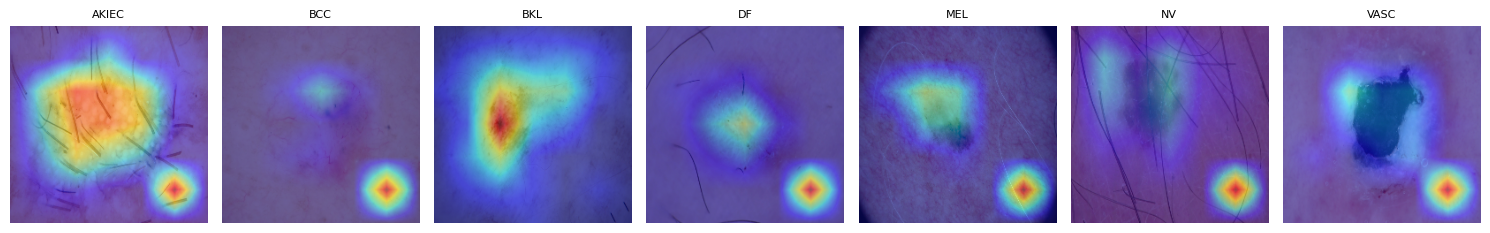

CPU times: user 15.2 s, sys: 1.95 s, total: 17.1 s
Wall time: 17.5 s


: 

In [ ]:
%%time
import cv2
import numpy as np
from matplotlib import pyplot as plt, cm
from tf_keras_vis.scorecam import Scorecam

# Assumptions:
# - model is your trained model
# - replace2linear is a valid model modifier function
# - X is the input tensor (preprocessed)
# - image_array contains the original images in [0, 1] range (float32)
# - image_titles contains class names

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate ScoreCAM heatmaps
cam = scorecam(score, X, penultimate_layer=-1, max_N=10)

# Number of images
num_images = len(image_titles)

# Create a single row plot
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, title in enumerate(image_titles):
    # Convert original image to uint8 RGB (matplotlib format)
    base_image = (image_array[i] * 255).astype(np.uint8)

    # Convert to BGR for OpenCV blending
    base_image_bgr = cv2.cvtColor(base_image, cv2.COLOR_RGB2BGR)

    # Create ScoreCAM heatmap as uint8 BGR
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    heatmap_bgr = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)

    # Blend image and heatmap
    blended_bgr = cv2.addWeighted(base_image_bgr, 0.5, heatmap_bgr, 0.5, 0)

    # Convert back to RGB for display
    blended_rgb = cv2.cvtColor(blended_bgr, cv2.COLOR_BGR2RGB)

    # Display
    axes[i].imshow(blended_rgb)
    axes[i].set_title(title, fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()
